In [3]:
import numpy as np
from skimage import io, color, transform
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import os
image_size = 256
# image = np.random.rand(image_size, image_size, 3)
# image[:, :, 0] = image[:, :, 0] * 100
# image[:, :, 1:] = image[:, :, 1:] * 256 - 128

D:\Anaconda\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


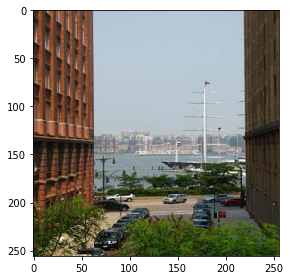

In [2]:
images = np.zeros((5, image_size, image_size, 3))
for index, image in enumerate(os.listdir("test")):
    images[index, :, :, :] = transform.resize(io.imread("test/" + image), (image_size, image_size))

io.imshow(images[2])
plt.show()
images = color.rgb2lab(images)

In [13]:
buckets = np.load("pts_in_hull.npy")
def bucketize_gaussian(images, buckets):
#     get ab channels only
    imagesAB = images[:, :, :, 1:]
#     calculate the distances from each pixel to each bucket
    distances = np.zeros((5*image_size*image_size, buckets.shape[0]))
    distances = cdist(imagesAB.reshape(5*image_size*image_size, 2), buckets)
    distances = distances.reshape(5*image_size*image_size, 313)
#     find five shortest ones  
    shortest_distances_indices = np.argpartition(distances, 5)
    five_shortest_distances_indices = shortest_distances_indices[:, :4]
    not_five_shortest_distances_indices = np.argpartition(distances, 5)[:, 5:]
#     zero the others
    vertical_indices = np.arange(5*image_size*image_size)[:, np.newaxis]
    distances[vertical_indices, not_five_shortest_distances_indices] = 0
#     pass gaussian kernel and normalize 5 shortest distances
    weights = np.exp(-distances[vertical_indices, five_shortest_distances_indices]**2/(2*5**2))
    weights_norm = weights/np.sum(weights, axis=1, keepdims=True)
    distances[vertical_indices, five_shortest_distances_indices] = weights_norm
    return distances.reshape(5, image_size, image_size, 313)
bucketize_gaussian(images, buckets)

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

D:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


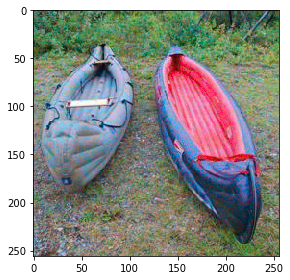

In [15]:
bucketized = bucketize_gaussian(images, buckets)
reverted = np.zeros((image_size, image_size, 3))
reverted[:, :, 0] = images[1, :, :, 0]
reverted[:, :, 1:] = buckets[np.argmax(bucketized[1], axis=2)]
io.imshow(color.lab2rgb(reverted))
plt.show()

In [ ]:
# colors = np.arange(-135, 145, 10)
# bins_to_colors = np.arange(-130, 140, 10)
# bins_to_colors[0] = -128
# bins_to_colors[-1] = 127
# print(bins_to_colors)
# bins = np.zeros((5, image_size, image_size))
# binned = np.zeros((5, image_size, image_size, 676))
# # image_colors_positived = images[:, :, :, 1:] + 133
# image_colors_in_bins = np.digitize(images[:, :, :, 1:], colors)
# image_colors_in_bins = image_colors_in_bins - 1
# one_hot = np.eye(676)
# bins = 26*image_colors_in_bins[:, :, :, 0] + image_colors_in_bins[:, :, :, 1]
# binned[:, :, :] = one_hot[bins[:, :, :]]
# print np.argwhere(binned[1]==1)[:, 2].reshape((image_size, image_size))

In [ ]:
# reverted_image = np.zeros((image_size, image_size, 3)).astype(int)
# image_binned = np.argwhere(binned[2, :, :]==1)[:, 2].reshape((image_size, image_size))
# reverted_image[:, :, 0] = images[2, :, :, 0]
# reverted_image[:, :, 2] = np.mod(image_binned ,np.full((image_size, image_size), 26))
# reverted_image[:, :, 1] = (image_binned - reverted_image[:, :, 2]) / 26


# reverted_image[:, :, 1:] = bins_to_colors[reverted_image[:, :, 1:]]
# reverted_image = reverted_image*1.0
# io.imshow(color.lab2rgb(reverted_image))

# plt.show()